# Analyze Trends Across Network Connectivity (Fig. S4)

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20231019

Using the large screen of many networks, this notebook will assess how various network properties vary with network connectivity.

In [1]:
import itertools
import math
import numpy as np
import os
import pathlib
import progressbar
import scipy.stats
import sys
import time

# Networkx for graphs - install instructions here https://networkx.org/documentation/stable/install.html
import networkx as nx

In [2]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
from dimer_network_utilities import *

In [ ]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [ ]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.2
matplotlib=3.5.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


In [ ]:
# Define directory to save to
# Note - this should be the same directory where results from 3_analyze_1D_screen.ipynb are saved
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [ ]:
# Define directory to load parameter screen from
load_dir = '/home/ubuntu/Data/20221108_1input_randomParamset'

In [ ]:
# Network sizes to test
m_list = list(range(3,13))

In [ ]:
# Load, if necessary
S_all_filenames_by_m = np.load(str(pathlib.Path(load_dir,'S_all_filenames_by_m.npy')),allow_pickle=True)
all_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'all_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
unfiltered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'unfiltered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
nonzero_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'nonzero_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)
filtered_curves_per_Sall_chunk_by_m = np.load(str(pathlib.Path(load_dir,'filtered_curves_per_Sall_chunk_by_m.npy')),allow_pickle=True)

In [ ]:
t = 30 # Number of input points simulated
input_lb = -3 # Lower bound of input range, in log space
input_ub = 3 # Lower bound of input range, in log space

## Local Extrema by Connectivity

This section will at networks of various connectivity and assess how many local minima and maxima exist in their one-input response functions.

In [ ]:
curve_types = [
    'monotonic',
    'max',
    'min',
    'max_min',
    'min_max',
    'max_min_max',
    'min_max_min',
]

curve_type_labels = [
    'Monotonic',
    'One-Maximum',
    'One-Minimum',
    'Maximum-Minimum',
    'Minimum-Maximum',
    'Maximum-Minimum-Maximum',
    'Minimum-Maximum-Minimum',
]

In [ ]:
min_affinity = 1e-5 # Affinity cutoff to be counted as an "edge"

def count_edges(param_set,min_affinity=1e-5):
    # Function to count the number of nonzero edges in a parameter set
    return np.where(param_set>=min_affinity)[0].shape[0]


In [ ]:
# Load number of parameter sets for each possible number of edges in a network, for each network size, from 3_analyze_1D_screen.ipynb
num_sets_per_num_edges_by_m = np.load(str(pathlib.Path(out_dir,f'num_sets_per_num_edges_by_m.npy')),allow_pickle=True)

In [ ]:
min_sets_per_num_edges = np.min(num_sets_per_num_edges_by_m) # Minimum number of parameter sets for each possible number of edges in a network; we will bootstrap this many networks for fairness across network sizes
num_bootstrap_samples = 5 # Number of bootstrap samples to take
rng = np.random.default_rng()

In [ ]:
# Iterate over network sizes
for m in m_list:
    m_i = m_list.index(m)
    print(f"Processing m={m}")
    max_hetero_edges = num_combos(m,r=2)
    max_homo_edges = m
    min_hetero_edges = m-1
    num_S_all_chunks = len(filtered_curves_per_Sall_chunk_by_m[m_i]) # Number of chunks simulation data was saved in
    # Load parameter sets
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'K_A_param_sets.npy')),allow_pickle=True)
    # Load info about which dimers are formed in each parameter set
    dimers_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)
    
    # Create key for types of edges
    homo_edges = []
    hetero_edges = []
    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)

    hetero_edges_by_param_set = np.apply_along_axis(count_edges, 1, param_sets[:,hetero_edges],min_affinity=min_affinity)
    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
        
    fraction_responses_by_extrema_by_hetero_edges = {name:[[] for x in hetero_edges_list] for name in curve_types}
    num_responses_by_extrema_by_hetero_edges = {name:[[] for x in hetero_edges_list] for name in curve_types}
    
    # If we are analyzing the largest network, we need only bootstrap once because we are using the full dataset
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples
    
    # Iterate over possible numbers of edges in each network (i.e., connectivity)
    for num_hetero_edges_i,num_hetero_edges in enumerate(progressbar.progressbar(hetero_edges_list)):
        # Find parameter sets with this number of edges
        param_set_idx_with_num_edges = np.where(hetero_edges_by_param_set==num_hetero_edges)[0]
        # Bootstrap to measure "numbers" of responses from each type
        for bootstrap_i in range(num_bootstrap_samples_temp):
            # Randomly sample parameter sets
            param_set_idx_with_num_edges_bootstrap = rng.choice(param_set_idx_with_num_edges,size=(min_sets_per_num_edges,),replace=False)
            # Identify which response curves came from those parameter sets
            curve_idx_with_num_edges = np.array(list(itertools.chain.from_iterable([list(range(param_set_id*(num_combos_with_replacement(m,r=2)),\
                        (param_set_id+1)*(num_combos_with_replacement(m,r=2)))) for param_set_id in param_set_idx_with_num_edges_bootstrap]))) # Unfiltered IDs
            num_unfiltered_ids = np.sum(dimers_by_param_set.reshape((-1,))[curve_idx_with_num_edges])
            num_filtered_ids = 0
            S_all_processed_filtered_num_edges = np.empty((0,t))
            # Iterate over chunks of simulation data
            for S_all_chunk in range(num_S_all_chunks):
                # Identify response curves that came from this chunk
                curve_idx_with_num_edges_in_chunk = curve_idx_with_num_edges[np.where((curve_idx_with_num_edges>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                                 & (curve_idx_with_num_edges<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs
                if curve_idx_with_num_edges_in_chunk.shape[0]==0:
                    continue
                curve_idx_with_num_edges_in_chunk = (curve_idx_with_num_edges_in_chunk-\
                                            np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64) # Unfiltered IDs, starting at 0 within chunk
                # Load responses
                S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
                univ_filter_map_filename = str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'univ_filter_map_{S_all_chunk}.npy'))
                univ_filter_map = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',univ_filter_map_filename)),allow_pickle=True)
                # Identify response curves that passed filtering, append to S_all_processed_filtered_num_edges
                curve_idx_with_num_edges_passed_filter = \
                    curve_idx_with_num_edges_in_chunk[np.isin(curve_idx_with_num_edges_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs, starting at 0 within chunk, that passed filtering
                curve_idx_with_num_edges_filtered = univ_filter_map[np.isin(univ_filter_map[:,0],curve_idx_with_num_edges_passed_filter)][:,1] # Filtered IDs, starting at 0 within chunk
                S_all_subset = S_all_processed_filtered[curve_idx_with_num_edges_filtered,:]
                num_filtered_ids += curve_idx_with_num_edges_filtered.shape[0]
                S_all_processed_filtered_num_edges = np.vstack((S_all_processed_filtered_num_edges,S_all_subset))
            # Analyze local extrema of bootstrapped response curves with this number of edges 
            local_mins, local_maxs, pos_inflection_points, neg_inflection_points = \
                        get_critical_points(np.log10(S_all_processed_filtered_num_edges),extrema_threshold=0.2,curves_per_chunk=10000)
            # Count number of responses from each functional class
            monotonic = np.intersect1d(np.where([x.shape[0]==0 for x in local_mins]),\
                        np.where([x.shape[0]==0 for x in local_maxs]))
            num_responses_by_extrema_by_hetero_edges['monotonic'][num_hetero_edges_i].append(monotonic.shape[0])

            max_ = np.intersect1d(np.where([x.shape[0]==0 for x in local_mins]),\
                                 np.where([x.shape[0]==1 for x in local_maxs]))
            num_responses_by_extrema_by_hetero_edges['max'][num_hetero_edges_i].append(max_.shape[0])

            min_ = np.intersect1d(np.where([x.shape[0]==1 for x in local_mins]),\
                                 np.where([x.shape[0]==0 for x in local_maxs]))
            num_responses_by_extrema_by_hetero_edges['min'][num_hetero_edges_i].append(min_.shape[0])

            max_and_min = np.intersect1d(np.where([x.shape[0]==1 for x in local_mins]),np.where([x.shape[0]==1 for x in local_maxs]))
            max_min = np.array([x for x in max_and_min if local_maxs[x][0]<local_mins[x][0]])
            min_max = np.array([x for x in max_and_min if local_mins[x][0]<local_maxs[x][0]])
            num_responses_by_extrema_by_hetero_edges['max_min'][num_hetero_edges_i].append(max_min.shape[0])
            num_responses_by_extrema_by_hetero_edges['min_max'][num_hetero_edges_i].append(min_max.shape[0])

            max2_and_min1 = np.intersect1d(np.where([x.shape[0]==1 for x in local_mins]),np.where([x.shape[0]==2 for x in local_maxs]))
            max_min_max = np.array([x for x in max2_and_min1 if (local_maxs[x][0]<local_mins[x][0]) and (local_mins[x][0]<local_maxs[x][1])])
            num_responses_by_extrema_by_hetero_edges['max_min_max'][num_hetero_edges_i].append(max_min_max.shape[0])

            max1_and_min2 = np.intersect1d(np.where([x.shape[0]==2 for x in local_mins]),np.where([x.shape[0]==1 for x in local_maxs]))
            min_max_min = np.array([x for x in max1_and_min2 if (local_mins[x][0]<local_maxs[x][0]) and (local_maxs[x][0]<local_mins[x][1])])
            num_responses_by_extrema_by_hetero_edges['min_max_min'][num_hetero_edges_i].append(min_max_min.shape[0])
        
        # But use whole dataset to measure "fraction" of each type of response
        curve_idx_with_num_edges = np.array(list(itertools.chain.from_iterable([list(range(param_set_id*(num_combos_with_replacement(m,r=2)),\
                    (param_set_id+1)*(num_combos_with_replacement(m,r=2)))) for param_set_id in param_set_idx_with_num_edges]))) # Unfiltered IDs
        num_unfiltered_ids = np.sum(dimers_by_param_set.reshape((-1,))[curve_idx_with_num_edges])
        num_filtered_ids = 0
        S_all_processed_filtered_num_edges = np.empty((0,t))
        # Iterate over chunks of simulation data
        for S_all_chunk in range(num_S_all_chunks):
            # Identify response curves that came from this chunk
            curve_idx_with_num_edges_in_chunk = curve_idx_with_num_edges[np.where((curve_idx_with_num_edges>=np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk]))\
                                             & (curve_idx_with_num_edges<np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk+1])))] # Unfiltered IDs
            if curve_idx_with_num_edges_in_chunk.shape[0]==0:
                continue
            curve_idx_with_num_edges_in_chunk = (curve_idx_with_num_edges_in_chunk-\
                                        np.sum(all_curves_per_Sall_chunk_by_m[m_i][:S_all_chunk])).astype(np.int64) # Unfiltered IDs, starting at 0 within chunk
            # Load responses
            S_all_processed_filtered = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'S_all_processed_filtered_{S_all_chunk}.npy')),allow_pickle=True)
            univ_filter_map_filename = str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'univ_filter_map_{S_all_chunk}.npy'))
            univ_filter_map = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',univ_filter_map_filename)),allow_pickle=True)
            # Identify response curves that passed filtering, append to S_all_processed_filtered_num_edges
            curve_idx_with_num_edges_passed_filter = \
                curve_idx_with_num_edges_in_chunk[np.isin(curve_idx_with_num_edges_in_chunk,univ_filter_map[:,0])] # Unfiltered IDs, starting at 0 within chunk, that passed filtering
            curve_idx_with_num_edges_filtered = univ_filter_map[np.isin(univ_filter_map[:,0],curve_idx_with_num_edges_passed_filter)][:,1] # Filtered IDs, starting at 0 within chunk
            S_all_subset = S_all_processed_filtered[curve_idx_with_num_edges_filtered,:]
            num_filtered_ids += curve_idx_with_num_edges_filtered.shape[0]
            S_all_processed_filtered_num_edges = np.vstack((S_all_processed_filtered_num_edges,S_all_subset))
        # Analyze local extrema of bootstrapped response curves with this number of edges 
        local_mins, local_maxs, pos_inflection_points, neg_inflection_points = \
                    get_critical_points(np.log10(S_all_processed_filtered_num_edges),extrema_threshold=0.2,curves_per_chunk=10000)
        # Count fraction of responses from each functional class
        monotonic = np.intersect1d(np.where([x.shape[0]==0 for x in local_mins]),\
                    np.where([x.shape[0]==0 for x in local_maxs]))
        fraction_responses_by_extrema_by_hetero_edges['monotonic'][num_hetero_edges_i].append(monotonic.shape[0]/num_filtered_ids)

        max_ = np.intersect1d(np.where([x.shape[0]==0 for x in local_mins]),\
                             np.where([x.shape[0]==1 for x in local_maxs]))
        fraction_responses_by_extrema_by_hetero_edges['max'][num_hetero_edges_i].append(max_.shape[0]/num_filtered_ids)

        min_ = np.intersect1d(np.where([x.shape[0]==1 for x in local_mins]),\
                             np.where([x.shape[0]==0 for x in local_maxs]))
        fraction_responses_by_extrema_by_hetero_edges['min'][num_hetero_edges_i].append(min_.shape[0]/num_filtered_ids)

        max_and_min = np.intersect1d(np.where([x.shape[0]==1 for x in local_mins]),np.where([x.shape[0]==1 for x in local_maxs]))
        max_min = np.array([x for x in max_and_min if local_maxs[x][0]<local_mins[x][0]])
        min_max = np.array([x for x in max_and_min if local_mins[x][0]<local_maxs[x][0]])
        fraction_responses_by_extrema_by_hetero_edges['max_min'][num_hetero_edges_i].append(max_min.shape[0]/num_filtered_ids)
        fraction_responses_by_extrema_by_hetero_edges['min_max'][num_hetero_edges_i].append(min_max.shape[0]/num_filtered_ids)

        max2_and_min1 = np.intersect1d(np.where([x.shape[0]==1 for x in local_mins]),np.where([x.shape[0]==2 for x in local_maxs]))
        max_min_max = np.array([x for x in max2_and_min1 if (local_maxs[x][0]<local_mins[x][0]) and (local_mins[x][0]<local_maxs[x][1])])
        fraction_responses_by_extrema_by_hetero_edges['max_min_max'][num_hetero_edges_i].append(max_min_max.shape[0]/num_filtered_ids)

        max1_and_min2 = np.intersect1d(np.where([x.shape[0]==2 for x in local_mins]),np.where([x.shape[0]==1 for x in local_maxs]))
        min_max_min = np.array([x for x in max1_and_min2 if (local_mins[x][0]<local_maxs[x][0]) and (local_maxs[x][0]<local_mins[x][1])])
        fraction_responses_by_extrema_by_hetero_edges['min_max_min'][num_hetero_edges_i].append(min_max_min.shape[0]/num_filtered_ids)
    for name in curve_types:
        np.save(str(pathlib.Path(out_dir,f'{m}M_'+f'fraction_responses_{name}_by_hetero_edges.npy')),fraction_responses_by_extrema_by_hetero_edges[name])
        np.save(str(pathlib.Path(out_dir,f'{m}M_'+f'num_responses_{name}_by_hetero_edges.npy')),num_responses_by_extrema_by_hetero_edges[name])

Plot results:

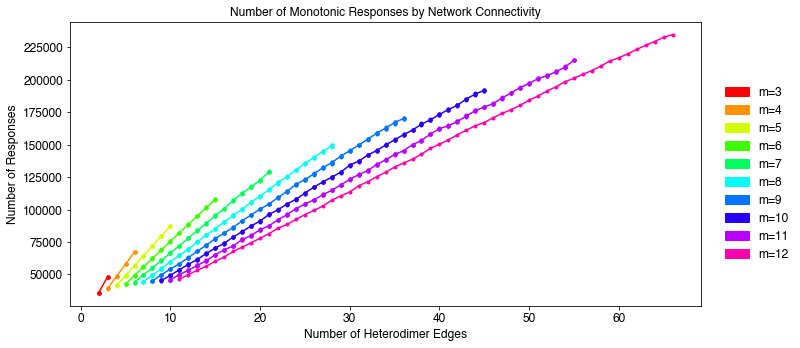

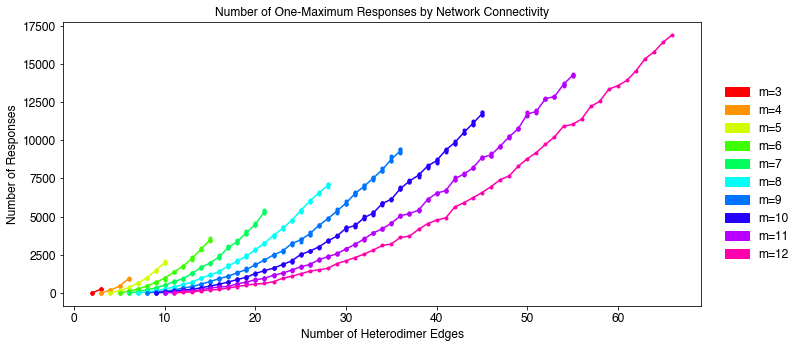

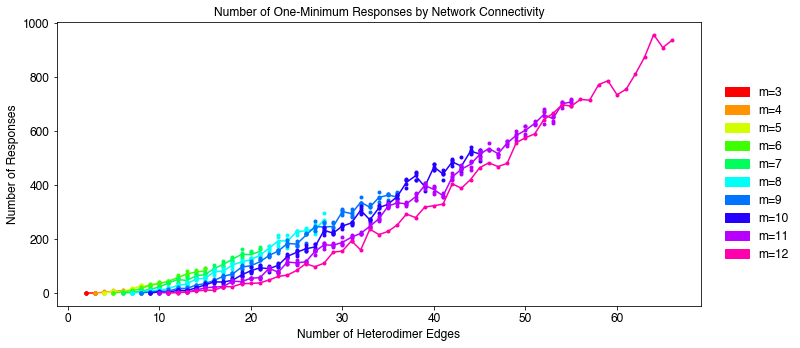

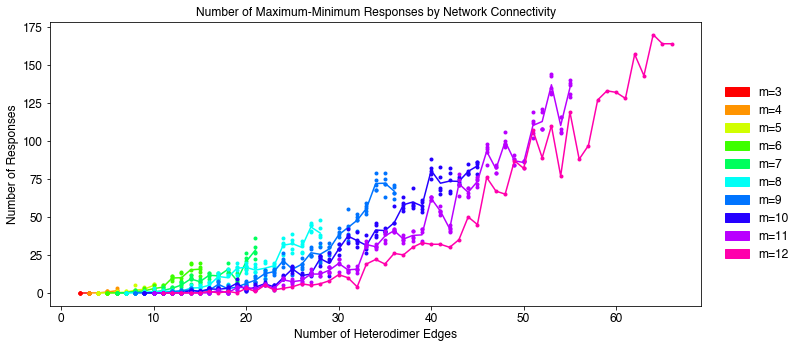

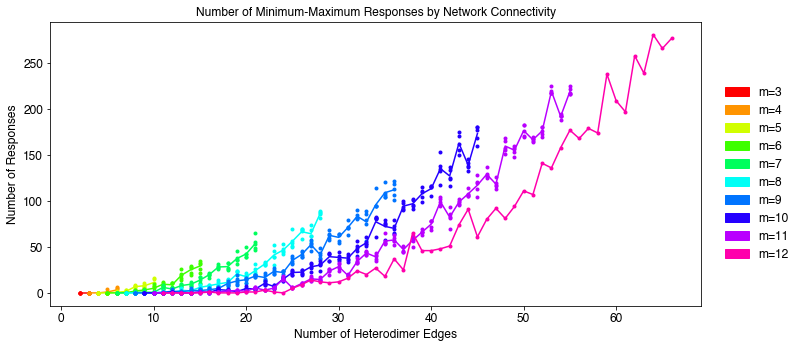

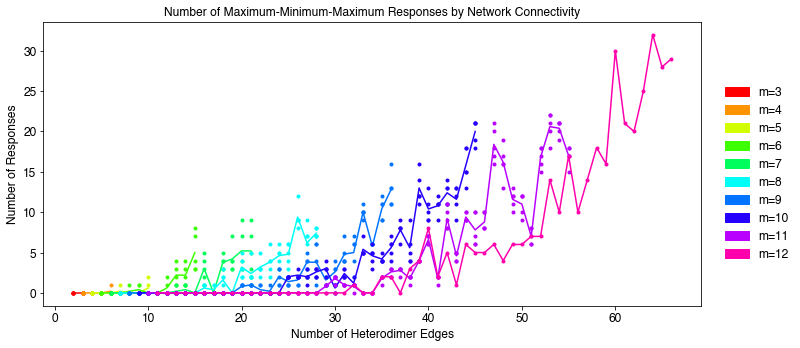

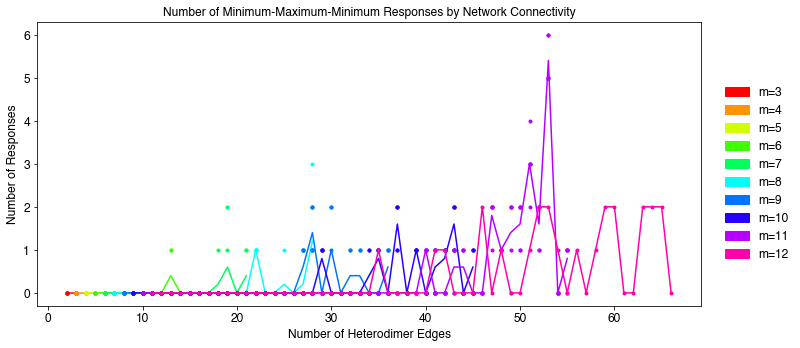

In [ ]:
# Iterate over types of curves by local extrema
for name,label in zip(curve_types,curve_type_labels):
    fig, ax = plt.subplots(figsize=(10,5))
    cmap = cm.get_cmap('hsv')
    rng = np.random.default_rng()

    # Iterate over network sizes (each has a different color)
    for m in m_list:
        m_i = m_list.index(m)
        # Load data
        num_responses_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_'+f'num_responses_{name}_by_hetero_edges.npy')),allow_pickle=True)
        max_hetero_edges = num_combos(m,r=2)
        min_hetero_edges = m -1
        hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
        # If this is the largest network, all samples were used, so only one bootstrap sample was taken
        if m == m_list[-1]:
            num_bootstrap_samples_temp = 1
        else:
            num_bootstrap_samples_temp = num_bootstrap_samples
        x_vals = list(itertools.chain.from_iterable([[x for i in range(num_bootstrap_samples_temp)] for x in hetero_edges_list]))
        y_val_means = [np.mean(x) for x in num_responses_by_hetero_edges]
        ax.plot(x_vals,list(itertools.chain.from_iterable(num_responses_by_hetero_edges)),\
                marker='.',linestyle='',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)
        ax.plot(hetero_edges_list,y_val_means,\
                marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

    _ = ax.set_xlabel('Number of Heterodimer Edges')
    _ = ax.set_ylabel('Number of Responses')
    _ = ax.set_title(f'Number of {label} Responses by Network Connectivity')

    # Make legend
    patches={}
    for m_i,m in enumerate(m_list):
        patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

    leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

    filename = f'num_responses_{name}_by_hetero_edges'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

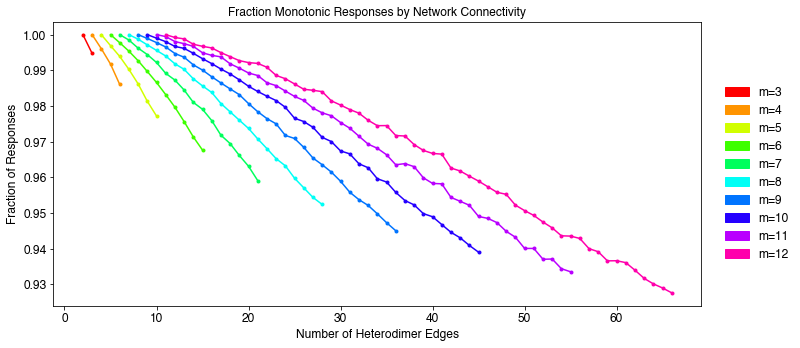

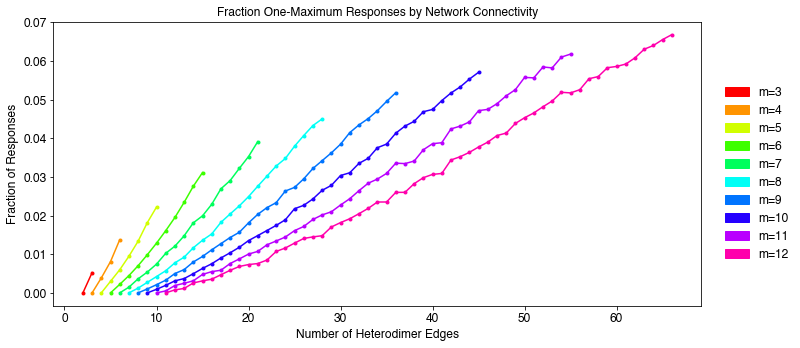

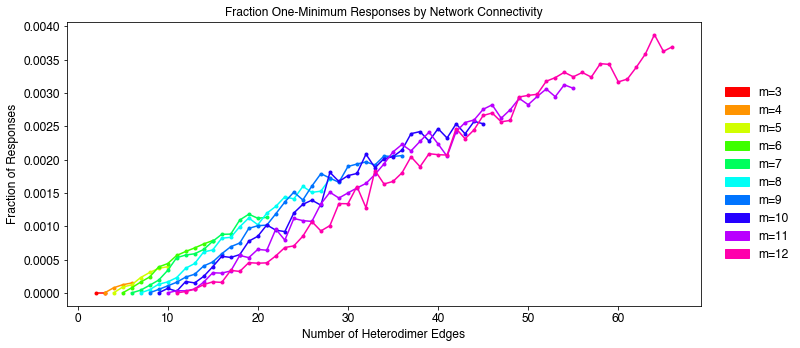

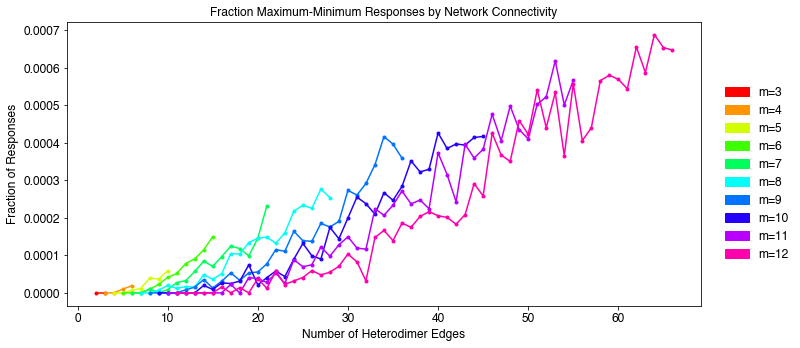

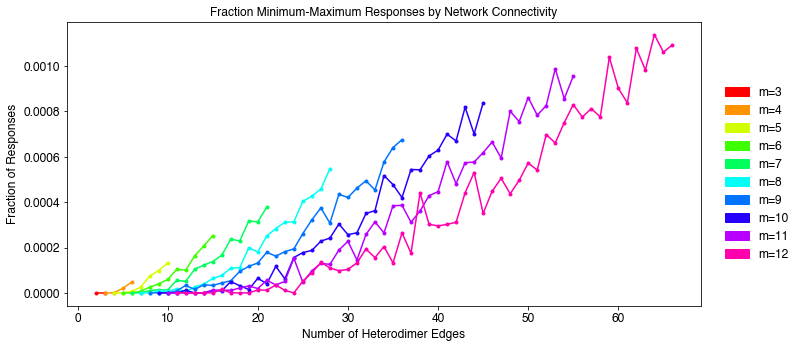

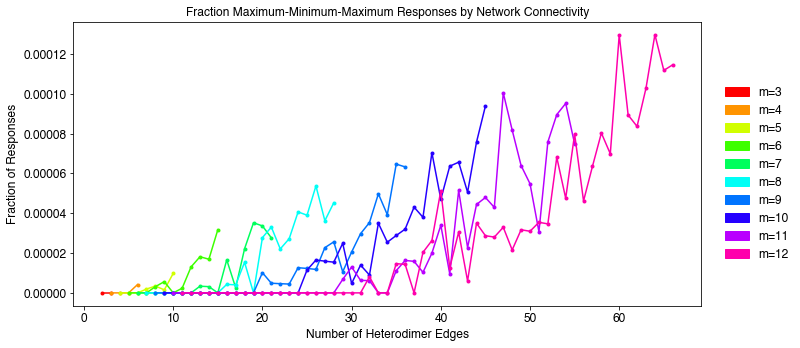

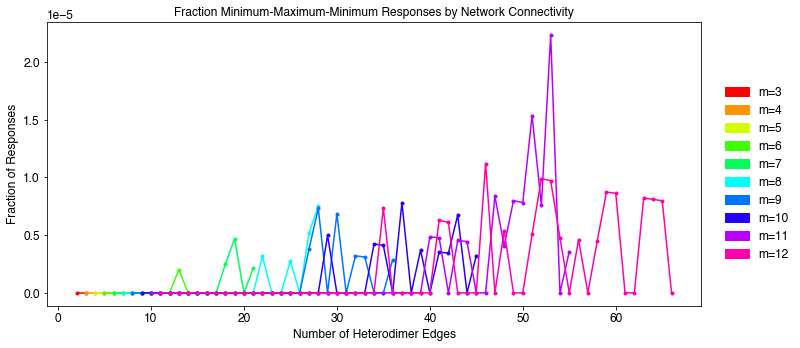

In [ ]:
# Iterate over types of curves by local extrema
for name,label in zip(curve_types,curve_type_labels):
    fig, ax = plt.subplots(figsize=(10,5))
    cmap = cm.get_cmap('hsv')
    rng = np.random.default_rng()
    # Iterate over network sizes (each has a different color)
    for m in m_list:
        m_i = m_list.index(m)
        # Load data
        fraction_responses_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_'+f'fraction_responses_{name}_by_hetero_edges.npy')),allow_pickle=True)
        max_hetero_edges = num_combos(m,r=2)
        min_hetero_edges = m -1
        hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
        ax.plot(hetero_edges_list,fraction_responses_by_hetero_edges,\
                marker='.',linestyle='-',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)

    _ = ax.set_xlabel('Number of Heterodimer Edges')
    _ = ax.set_ylabel('Fraction of Responses')
    _ = ax.set_title(f'Fraction {label} Responses by Network Connectivity')

    # Make legend
    patches={}
    for m_i,m in enumerate(m_list):
        patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

    leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

    filename = f'fraction_responses_{name}_by_hetero_edges'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## "Distance" from each Monomer to the Input Monomer, by Connectivity

The distance from any given monomer to the input monomer is defined as the shortest possible path, using the network edges, between the two monomers. We analyze here how these distances change as connectivity is increased. Note that, by definition, in a fully connected network, all monomers are connected to the input (only 1 edge away)

First, measure the distance from the input for all monomers in all parameter sets

In [ ]:
min_affinity = 1e-5 # Affinity cutoff to be counted as an "edge"

# Iterate over network sizes
for m_i, m in enumerate(m_list):
    print(f"Working on m={m}")
    # Load parameter sets
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'K_A_param_sets.npy')),allow_pickle=True)
    distance_to_input_by_monomer_by_param_set = np.zeros((param_sets.shape[0],m-1))

    # Categorize types of edges
    homo_edges = []
    hetero_edges = []
    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)
    homo_edges = np.array(homo_edges)
    hetero_edges = np.array(hetero_edges)
    possible_hetero_edges = np.array(list(itertools.combinations(range(m),r=2)))
    # Create a Networkx object of each particular parameter set
    G_base = nx.Graph()
    G_base.add_nodes_from(list(range(m)))
    for param_set in progressbar.progressbar(range(param_sets.shape[0])):
        G = G_base.copy()
        G.add_edges_from(possible_hetero_edges[np.where(param_sets[param_set,hetero_edges]>=min_affinity)[0]])
        # Use nx.shortest_path_length to identify the distance from the input monomer
        distance_to_input_by_monomer_by_param_set[param_set] = np.array([nx.shortest_path_length(G, source=0, target=monomer) for monomer in range(1,m)])
    np.save(str(pathlib.Path(out_dir,f'{m}M_distance_to_input_by_monomer_by_param_set.npy')),distance_to_input_by_monomer_by_param_set)

Then, we will analyze how this statistic varies with network connectivity (i.e., the number of network edges)

In [ ]:
# Iterate over network size
for m_i, m in enumerate(m_list):
    print(f"Processing m={m}")
    max_hetero_edges = num_combos(m,r=2)
    max_homo_edges = m
    min_hetero_edges = m-1
    num_S_all_chunks = len(filtered_curves_per_Sall_chunk_by_m[m_i])
    # Load data
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'K_A_param_sets.npy')),allow_pickle=True)
    distance_to_input_by_monomer_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_distance_to_input_by_monomer_by_param_set.npy')),allow_pickle=True)
    
    # Categorize edge types
    homo_edges = []
    hetero_edges = []

    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)
    all_edges = homo_edges+hetero_edges

    # Calculate number of heterodimer edges in each parameter set
    hetero_edges_by_param_set = np.apply_along_axis(count_edges, 1, param_sets[:,hetero_edges])
    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
        
    distance_to_input_by_hetero_edges = []
    # Iterate over numbers of heterodimer edges (i.e., connectivity)
    for i,num_hetero_edges in enumerate(hetero_edges_list):
        # Identify parameter sets with this number of edges
        param_set_idx_with_num_edges = np.where(hetero_edges_by_param_set==num_hetero_edges)[0]
        distance_to_input_by_hetero_edges.append([distance_to_input_by_monomer_by_param_set[param_set_id] for param_set_id in param_set_idx_with_num_edges])
    
    np.save(str(pathlib.Path(out_dir,f'{m}M_distance_to_input_by_hetero_edges.npy')),distance_to_input_by_hetero_edges)

Plot:

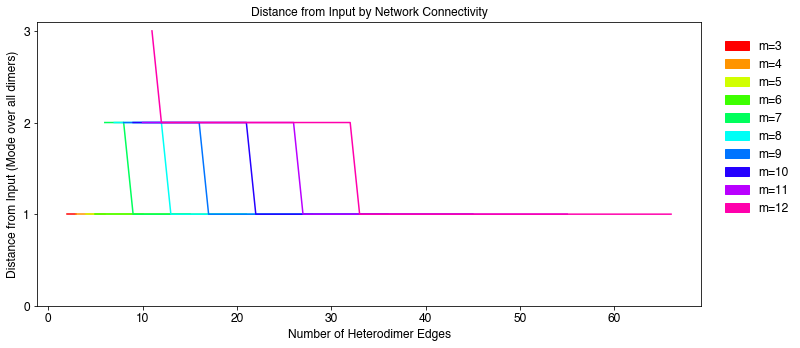

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = cm.get_cmap('hsv')
rng = np.random.default_rng()

# Iterate over network sizes
for m_i,m in enumerate(m_list):
    # Load data
    distance_to_input_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_distance_to_input_by_hetero_edges.npy')),allow_pickle=True)
    max_hetero_edges = num_combos(m,r=2)
    min_hetero_edges = m -1
    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
    statistic_by_hetero_edges = []
    # Iterate over numbers of heterodimer edges (i.e., connectivity)
    for i,num_hetero_edges in enumerate(range(min_hetero_edges,max_hetero_edges+1)):
        points = np.array(list(itertools.chain.from_iterable(distance_to_input_by_hetero_edges[i])),dtype=np.int64)
        # Calulate some statistic on the points:
        statistic_by_hetero_edges.append(scipy.stats.mode(points,keepdims=False)[0])
        
    # Plot some statistic on the points:
    ax.plot(hetero_edges_list,statistic_by_hetero_edges,\
            marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel('Distance from Input (Mode over all dimers)')
_ = ax.set_title(f'Distance from Input by Network Connectivity')
_ = ax.set_yticks(list(range(0,math.ceil(ax.get_ylim()[1]))))

# Add legend
patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.9), loc='upper left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'distance_from_input_by_fraction_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Number of Paths to Input (up to length 3)

We will measure the different paths relating each dimer to the input, with lengths 1, 2, or 3. Note that our search limit of length 3 is backed up both by our empirical data and previous literature suggesting concentration changes tend not to propogate further.

We expect the average number of paths to the input to increase with connectivity. The "paths" are important because each path defines whether we would expect a dimer to increase or decrease with increasing input.

In [ ]:
max_edge_path_length = 3 # Maximum path length to look for

In [ ]:
min_affinity = 1e-5 # Affinity cutoff to be counted as an "edge"

def count_edges(param_set,min_affinity=1e-5):
    return np.where(param_set>=min_affinity)[0].shape[0]


First we will calculate paths to the input for all dimers in all parameter sets

In [ ]:
# Iterate over network sizes
for m in m_list:
    m_i = m_list.index(m)
    print(f"Working on m={m}")
    # Load parameter sets and info about which dimers are actually possible
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'K_A_param_sets.npy')),allow_pickle=True)
    dimers_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)
    paths_to_input_by_length_by_param_set_by_dimer = [np.zeros((param_sets.shape[0],num_combos_with_replacement(m,2),3))\
                                            for x in range(max_edge_path_length)]
    # Categorize edges by type and create key for which monomers are in which dimer
    homo_edges = []
    hetero_edges = []
    dimer_constituents = list(itertools.combinations_with_replacement(range(m),r=2))
    for i,combo in enumerate(dimer_constituents):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)
    homo_edges = np.array(homo_edges)
    hetero_edges = np.array(hetero_edges)
    possible_hetero_edges = np.array(list(itertools.combinations(range(m),r=2)))
    # Create Networkx object for each parameter set
    G_base = nx.Graph()
    G_base.add_nodes_from(list(range(m)))
    # Iterate over parameter sets
    for param_set in progressbar.progressbar(range(param_sets.shape[0])):
        G = G_base.copy()
        G.add_edges_from(possible_hetero_edges[np.where(param_sets[param_set,hetero_edges]>=min_affinity)[0]])
        # Iterate over dimers in this parameter set
        for dimer in range(num_combos_with_replacement(m,2)):
            if not dimers_by_param_set[param_set,dimer] or dimer==0:
                continue
            if dimer in homo_edges:
                # Use nx.all_simple_paths to calculate paths from the monomer to input
                paths = list(nx.all_simple_paths(G, source=0, target=dimer_constituents[dimer][0],cutoff=max_edge_path_length))
                for pathlength_i,pathlength in enumerate(range(1,max_edge_path_length+1)):
                    paths_to_input_by_length_by_param_set_by_dimer[pathlength_i][param_set,dimer,:] = \
                            len([x for x in paths if len(x)==pathlength+1])
            elif dimer in hetero_edges:
                # Use nx.all_simple_paths to calculate paths from each monomer to input
                paths0 = list(nx.all_simple_paths(G, source=0, target=dimer_constituents[dimer][0],cutoff=max_edge_path_length))
                paths0 = [x for x in paths0 if dimer_constituents[dimer][1] not in x]
                paths1 = list(nx.all_simple_paths(G, source=0, target=dimer_constituents[dimer][1],cutoff=max_edge_path_length))
                paths1 = [x for x in paths1 if dimer_constituents[dimer][0] not in x]
                for pathlength_i,pathlength in enumerate(range(1,max_edge_path_length+1)):
                    paths_to_input_by_length_by_param_set_by_dimer[pathlength_i][param_set,dimer,0] = \
                                    len([x for x in paths0 if len(x)==pathlength+1])
                    paths_to_input_by_length_by_param_set_by_dimer[pathlength_i][param_set,dimer,1] = \
                                    len([x for x in paths1 if len(x)==pathlength+1])
        # Save checkpoints
        if param_set%50000==0 and param_set!=0:
            for pathlength_i,pathlength in enumerate(range(1,max_edge_path_length+1)):
                np.save(str(pathlib.Path(out_dir,f'{m}M_'+f'num_paths_to_input_{pathlength}_by_param_set_by_dimer_temp.npy')),paths_to_input_by_length_by_param_set_by_dimer[pathlength_i])
    # Calculate "total paths" by summing over monomers (unless homodimer)
    where_dimers = np.where(dimers_by_param_set)
    where_homodimers = (where_dimers[0][np.isin(where_dimers[1],homo_edges)],where_dimers[1][np.isin(where_dimers[1],homo_edges)])
    for pathlength_i,pathlength in enumerate(range(1,max_edge_path_length+1)):
        # Make sum as third column
        paths_to_input_by_length_by_param_set_by_dimer[pathlength_i][:,:,2] = np.sum(paths_to_input_by_length_by_param_set_by_dimer[pathlength_i][:,:,:2],axis=-1)
        # Set sum for homodimers to just same number
        paths_to_input_by_length_by_param_set_by_dimer[pathlength_i][where_homodimers[0],where_homodimers[1],2] = paths_to_input_by_length_by_param_set_by_dimer[pathlength_i][where_homodimers[0],where_homodimers[1],0]
        np.save(str(pathlib.Path(out_dir,f'{m}M_'+f'num_paths_to_input_{pathlength}_by_param_set_by_dimer.npy')),paths_to_input_by_length_by_param_set_by_dimer[pathlength_i])
        os.remove(str(pathlib.Path(out_dir,f'{m}M_'+f'num_paths_to_input_{pathlength}_by_param_set_by_dimer_temp.npy')))

Now assess how these paths change with network connectivity (i.e., number of edges in the network)

In [ ]:
# Iterate over network sizes
for m in m_list:
    m_i = m_list.index(m)
    print(f"Processing m={m}")
    max_hetero_edges = num_combos(m,r=2)
    max_homo_edges = m
    min_hetero_edges = m-1
    num_S_all_chunks = len(filtered_curves_per_Sall_chunk_by_m[m_i])
    # Load parameter sets and info about which dimers are actually possible
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'K_A_param_sets.npy')),allow_pickle=True)
    dimers_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)
    
    # Categorize edges by type
    homo_edges = []
    hetero_edges = []

    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)

    hetero_edges_by_param_set = np.apply_along_axis(count_edges, 1, param_sets[:,hetero_edges],min_affinity=min_affinity)
    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
        
    num_paths_to_input_by_length_by_hetero_edges = [[] for pathlength in range(1,max_edge_path_length+1)]
    
    # Iterate over pathlengths (1,2,3)
    for pathlength_i,pathlength in enumerate(range(1,max_edge_path_length+1)):
        paths_to_input_by_param_set_by_dimer = np.load(str(pathlib.Path(out_dir,f'{m}M_'+f'num_paths_to_input_{pathlength}_by_param_set_by_dimer.npy')),allow_pickle=True)
        # Iterate over network connectivity
        for num_hetero_edges_i,num_hetero_edges in enumerate(hetero_edges_list):
            # Identify parameter sets with this number of edges
            param_set_idx_with_num_edges = np.where(hetero_edges_by_param_set==num_hetero_edges)[0]
            num_paths_to_input_by_length_by_hetero_edges[pathlength_i].append(\
                    paths_to_input_by_param_set_by_dimer[param_set_idx_with_num_edges,:,:].reshape(\
                    -1,paths_to_input_by_param_set_by_dimer.shape[-1]))
    for pathlength_i,pathlength in enumerate(range(1,max_edge_path_length+1)):
        np.save(str(pathlib.Path(out_dir,f'{m}M_'+f'num_paths_to_input_{pathlength}_by_hetero_edges.npy')),num_paths_to_input_by_length_by_hetero_edges[pathlength_i])

There are many ways of slicing/plotting this data, all of which we tried, but in this demonstration we simply plot the following:

For a particular connectivity value, how many dimers are observed that exhibit at least one path each of length 1, 2, AND 3?

In [ ]:
allatleast_total = [1,1,1]

def count_dimers_allatleast_total(num_paths_to_input_by_length_by_dimer):
    return np.where((num_paths_to_input_by_length_by_dimer[0,:,2]>=allatleast_total[0])&\
                   (num_paths_to_input_by_length_by_dimer[1,:,2]>=allatleast_total[1])&\
                   (num_paths_to_input_by_length_by_dimer[2,:,2]>=allatleast_total[2]))[0].shape[0]

In [ ]:
# We will bootstrap parameter sets to ensure different network sizes have equivalent numbers of networks per connectivity value
num_sets_per_num_edges_by_m = np.load(str(pathlib.Path(out_dir,f'num_sets_per_num_edges_by_m.npy')),allow_pickle=True)

min_sets_per_num_edges = np.min(num_sets_per_num_edges_by_m) # Minimum number of parameter sets for a particular connectivity value; so we will bootstrap this many parameter sets
num_bootstrap_samples = 5 # Number of bootstrap samples to take
rng = np.random.default_rng()

Working on m=3


100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


Working on m=4


100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


Working on m=5


100% (7 of 7) |##########################| Elapsed Time: 0:00:03 Time:  0:00:03


Working on m=6


100% (11 of 11) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


Working on m=7


100% (16 of 16) |########################| Elapsed Time: 0:00:08 Time:  0:00:08


Working on m=8


100% (22 of 22) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Working on m=9


100% (29 of 29) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Working on m=10


100% (37 of 37) |########################| Elapsed Time: 0:00:35 Time:  0:00:35


Working on m=11


100% (46 of 46) |########################| Elapsed Time: 0:00:54 Time:  0:00:54


Working on m=12


100% (56 of 56) |########################| Elapsed Time: 0:00:16 Time:  0:00:16


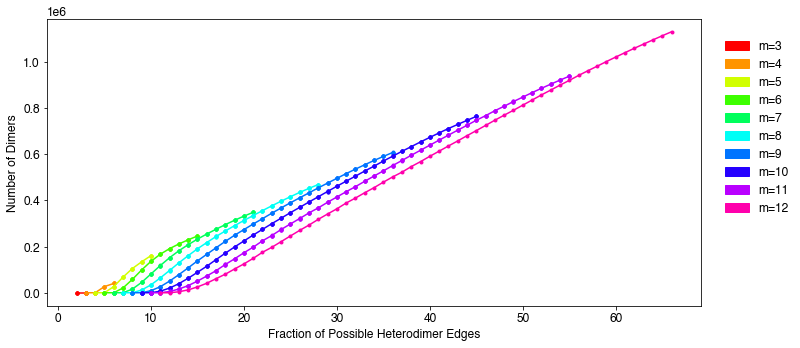

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

cmap = cm.get_cmap('hsv')
rng = np.random.default_rng()

# Iterate over network sizes (will be different colors)
for m in m_list:
    print(f"Working on m={m}")
    m_i = m_list.index(m)
    num_paths_to_input_by_length_by_hetero_edges = []
    for pathlength_i,pathlength in enumerate(range(1,max_edge_path_length+1)):
        num_paths_to_input_by_length_by_hetero_edges.append(np.load(str(pathlib.Path(out_dir,f'{m}M_'+f'num_paths_to_input_{pathlength}_by_hetero_edges.npy')),allow_pickle=True))
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'K_A_param_sets.npy')),allow_pickle=True)
    max_hetero_edges = num_combos(m,r=2)
    min_hetero_edges = m -1
    num_possible_num_edges = max_hetero_edges - min_hetero_edges + 1
    num_sets_per_num_edges = param_sets.shape[0]//num_possible_num_edges
    curves_per_param_set = num_combos_with_replacement(m,2)
    
    # If this is the last network size, we will only take one bootstrap sample, since every parameter set is used
    if m == m_list[-1]:
        num_bootstrap_samples_temp = 1
    else:
        num_bootstrap_samples_temp = num_bootstrap_samples

    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
    num_dimers_by_fraction_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    # Iterate over network connectivity (i.e., number of heterodimer edges)
    for num_hetero_edges_i,num_hetero_edges in enumerate(progressbar.progressbar(hetero_edges_list)):
        # Because we are counting dimers and want a fair comparison, we will bootstrap parameter sets to sample the same number of parameter sets from all network sizes
        for bootstrap_i in range(num_bootstrap_samples_temp):
            # Randomly select parameter sets
            param_set_idx_bootstrap = rng.choice(np.arange(num_sets_per_num_edges),size=(min_sets_per_num_edges,),replace=False)
            # Identify responses that came from these parameter sets
            curve_idx_bootstrap = np.array(list(itertools.chain.from_iterable([list(range(param_set_id*curves_per_param_set,\
                        (param_set_id+1)*curves_per_param_set)) for param_set_id in param_set_idx_bootstrap]))) # Unfiltered IDs
            # Analyze these dimers and count the number that meet the criteria
            num_dimers = count_dimers_allatleast_total(np.array([num_paths_to_input_by_length_by_hetero_edges[pathlength_i][num_hetero_edges_i,curve_idx_bootstrap,:]\
                                          for pathlength_i,pathlength in enumerate(range(1,max_edge_path_length+1))]))
            num_dimers_by_fraction_hetero_edges[num_hetero_edges_i].append(num_dimers)
    x_vals = list(itertools.chain.from_iterable([[x for i in range(num_bootstrap_samples_temp)] for x in hetero_edges_list]))
    y_val_means = [np.mean(x) for x in num_dimers_by_fraction_hetero_edges]
    ax.plot(x_vals,list(itertools.chain.from_iterable(num_dimers_by_fraction_hetero_edges)),\
            marker='.',linestyle='',markersize=8,markeredgewidth=0,color=cmap(m_i/(len(m_list))),alpha=1)
    ax.plot(hetero_edges_list,y_val_means,\
            marker='',linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)
    
_ = ax.set_xlabel('Fraction of Possible Heterodimer Edges')
_ = ax.set_ylabel('Number of Dimers')
_ = ax.set_title(f'Number of Dimers with Paths to Input of Length 1, 2, and 3')

# Make legend
patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.9), loc='upper left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')


filename = f'num_dimers_1_2_and3_paths_to_input_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Cliques

A clique is a fully connected subgraph of the network. For example, a 3-clique is a "triangle". We will only consider cliques of size 3 or 4 here. We expect that more densely connected networks will exhibit more cliques.

We asked about cliques because it may be possible that cliques allow for particular functions, such as how a 3-clique can be used to compute a one-input bandpass filter.

In [ ]:
min_size_clique = 3
max_size_clique = 4
size_options = list(range(min_size_clique,max_size_clique+1))
num_options = len(size_options)

First we will identify all cliques in all networks

In [ ]:
min_affinity = 1e-5 # Affinity cutoff to be counted as an "edge"

# Iterate over network sizes
for m in m_list:
    m_i = m_list.index(m)
    print(f"Working on m={m}")
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'K_A_param_sets.npy')),allow_pickle=True)
    dimers_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)

    # Categorize edges by homodimer or heterodimer
    homo_edges = []
    hetero_edges = []
    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)
    homo_edges = np.array(homo_edges)
    hetero_edges = np.array(hetero_edges)
    dimer_ids = list(itertools.combinations_with_replacement(range(m),r=2))
    possible_hetero_edges = np.array(list(itertools.combinations(range(m),r=2)))

    # Make Networkx object for each parameter set
    G_base = nx.Graph()
    G_base.add_nodes_from(list(range(m)))
    
    cliques_bysize_by_param_set = [np.zeros((param_sets.shape[0],),dtype=np.int64) for x in range(num_options)]
    cliques_bysize_by_param_set_withinput = [np.zeros((param_sets.shape[0],),dtype=np.int64) for x in range(num_options)]
    in_clique_by_size_by_param_set_by_dimer = [np.zeros((param_sets.shape[0],num_combos_with_replacement(m,2)),dtype=np.int64) for x in range(num_options)]
    in_clique_withinput_by_size_by_param_set_by_dimer = [np.zeros((param_sets.shape[0],num_combos_with_replacement(m,2)),dtype=np.int64) for x in range(num_options)]
    # Iterate over parameter sets
    for param_set in progressbar.progressbar(range(param_sets.shape[0])):
        G = G_base.copy()
        G.add_edges_from(possible_hetero_edges[np.where(param_sets[param_set,hetero_edges]>=min_affinity)[0]])
        # Find all cliques of size 3 and 4 using nx.enumerate_all_cliques
        cliques_bysize = [[] for size in size_options]
        cliques_withinput_bysize = [[] for size in size_options]
        for clique in nx.enumerate_all_cliques(G):
            if len(clique)>=min_size_clique:
                if len(clique)<=max_size_clique:
                    cliques_bysize[size_options.index(len(clique))].append(clique)
                    if 0 in clique:
                        cliques_withinput_bysize[size_options.index(len(clique))].append(clique)
                else:
                    break
        where_dimers = np.where(dimers_by_param_set[param_set])[0]
        # Iterate over clique size, keep track of which monomers are in a clique
        for size_i,size in enumerate(size_options):
            monomers_in_size_cliques = np.unique(list(itertools.chain.from_iterable(cliques_bysize[size_i])))
            dimers_in_size_cliques = [i for i,x in enumerate(dimer_ids) if x[0] in monomers_in_size_cliques or x[1] in monomers_in_size_cliques]
            dimers_in_size_cliques = np.intersect1d(np.array(dimers_in_size_cliques),where_dimers).astype(np.int64)
            in_clique_by_size_by_param_set_by_dimer[size_i][param_set,dimers_in_size_cliques]= 1
            #
            monomers_in_size_cliques = np.unique(list(itertools.chain.from_iterable(cliques_withinput_bysize[size_i])))
            dimers_in_size_cliques = [i for i,x in enumerate(dimer_ids) if x[0] in monomers_in_size_cliques or x[1] in monomers_in_size_cliques]
            dimers_in_size_cliques = np.intersect1d(np.array(dimers_in_size_cliques),where_dimers).astype(np.int64)
            in_clique_withinput_by_size_by_param_set_by_dimer[size_i][param_set,dimers_in_size_cliques]= 1
            #
            cliques_bysize_by_param_set[size_i][param_set] = len(cliques_bysize[size_i])
            cliques_bysize_by_param_set_withinput[size_i][param_set] = len(cliques_withinput_bysize[size_i])
    for size_i,size in enumerate(size_options):
        np.save(str(pathlib.Path(out_dir,f'{m}M_num_{size}cliques_by_param_set.npy')),cliques_bysize_by_param_set[size_i])
        np.save(str(pathlib.Path(out_dir,f'{m}M_num_{size}cliques_withinput_by_param_set.npy')),cliques_bysize_by_param_set_withinput[size_i])
        np.save(str(pathlib.Path(out_dir,f'{m}M_dimersin_{size}cliques_by_param_set.npy')),in_clique_by_size_by_param_set_by_dimer[size_i])
        np.save(str(pathlib.Path(out_dir,f'{m}M_dimersin_{size}cliques_withinput_by_param_set.npy')),in_clique_withinput_by_size_by_param_set_by_dimer[size_i])

Now we will assess how these cliques vary with network connectivity:

In [ ]:
# We will bootstrap parameter sets to ensure different network sizes have equivalent numbers of networks per connectivity value
num_sets_per_num_edges_by_m = np.load(str(pathlib.Path(out_dir,f'num_sets_per_num_edges_by_m.npy')),allow_pickle=True)

min_sets_per_num_edges = np.min(num_sets_per_num_edges_by_m) # Minimum number of parameter sets for a particular connectivity value; so we will bootstrap this many parameter sets
num_bootstrap_samples = 5 # Number of bootstrap samples to take
rng = np.random.default_rng()

In [ ]:
# Iterate over network sizes
for m in m_list:
    m_i = m_list.index(m)
    print(f"Processing m={m}")
    max_hetero_edges = num_combos(m,r=2)
    max_homo_edges = m
    min_hetero_edges = m-1
    num_S_all_chunks = len(filtered_curves_per_Sall_chunk_by_m[m_i])
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'K_A_param_sets.npy')),allow_pickle=True)
    cliques_bysize_by_param_set = []
    cliques_bysize_by_param_set_withinput = []
    in_clique_by_size_by_param_set_by_dimer = []
    in_clique_withinput_by_size_by_param_set_by_dimer = []
    # Iterate over clique sizes
    for size_i,size in enumerate(size_options):
        cliques_bysize_by_param_set.append(np.load(str(pathlib.Path(out_dir,f'{m}M_num_{size}cliques_by_param_set.npy')),allow_pickle=True))
        cliques_bysize_by_param_set_withinput.append(np.load(str(pathlib.Path(out_dir,f'{m}M_num_{size}cliques_withinput_by_param_set.npy')),allow_pickle=True))
        in_clique_by_size_by_param_set_by_dimer.append(np.load(str(pathlib.Path(out_dir,f'{m}M_dimersin_{size}cliques_by_param_set.npy')),allow_pickle=True))
        in_clique_withinput_by_size_by_param_set_by_dimer.append(np.load(str(pathlib.Path(out_dir,f'{m}M_dimersin_{size}cliques_withinput_by_param_set.npy')),allow_pickle=True))
    
    # Categorize edges by type
    homo_edges = []
    hetero_edges = []

    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)

    hetero_edges_by_param_set = np.apply_along_axis(count_edges, 1, param_sets[:,hetero_edges])
    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
    
    min_size_clique = 3
    max_size_clique = 4
    size_options = list(range(min_size_clique,max_size_clique+1))
    num_options = len(size_options)
    num_cliques_by_size_by_hetero_edges_by_paramset = [[] for x in size_options]
    num_cliques_withinput_by_size_by_hetero_edges_by_paramset = [[] for x in size_options]
    num_dimersinclique_by_size_by_hetero_edges = [[[] for num_hetero_edges in hetero_edges_list] for x in size_options]
    num_dimersinclique_withinput_by_size_by_hetero_edges = [[[] for num_hetero_edges in hetero_edges_list] for x in size_options]
    # Iterate over connectivity values (i.e., number of heterodimer edges)
    for num_hetero_edges_i,num_hetero_edges in enumerate(progressbar.progressbar(hetero_edges_list)):
        # Identify parameter sets with this number of edges
        param_set_idx_with_num_edges = np.where(hetero_edges_by_param_set==num_hetero_edges)[0]
        # For number of cliques per parameter set, no need for boostrapping
        for size_i,size in enumerate(size_options):
            num_cliques_by_size_by_hetero_edges_by_paramset[size_i].append(cliques_bysize_by_param_set[size_i][param_set_idx_with_num_edges])
            num_cliques_withinput_by_size_by_hetero_edges_by_paramset[size_i].append(cliques_bysize_by_param_set_withinput[size_i][param_set_idx_with_num_edges])
        # But to have a fair comparison for number of dimers, need to bootstrap
        for bootstrap_i in range(num_bootstrap_samples_temp):
            param_set_idx_with_num_edges_bootstrap = rng.choice(param_set_idx_with_num_edges,size=(min_sets_per_num_edges,),replace=False)
            for size_i,size in enumerate(size_options):
                num_dimersinclique_by_size_by_hetero_edges[size_i][num_hetero_edges_i].append(np.sum(in_clique_by_size_by_param_set_by_dimer[size_i][param_set_idx_with_num_edges_bootstrap,:]))
                num_dimersinclique_withinput_by_size_by_hetero_edges[size_i][num_hetero_edges_i].append(np.sum(in_clique_withinput_by_size_by_param_set_by_dimer[size_i][param_set_idx_with_num_edges_bootstrap,:]))
    for size_i,size in enumerate(size_options):
        np.save(str(pathlib.Path(out_dir,f'{m}M_num_{size}cliques_by_hetero_edges_by_paramset.npy')),num_cliques_by_size_by_hetero_edges_by_paramset[size_i])
        np.save(str(pathlib.Path(out_dir,f'{m}M_num_{size}cliques_withinput_by_hetero_edges_by_paramset.npy')),num_cliques_withinput_by_size_by_hetero_edges_by_paramset[size_i])
        np.save(str(pathlib.Path(out_dir,f'{m}M_num_dimersin{size}clique_by_hetero_edges.npy')),num_dimersinclique_by_size_by_hetero_edges[size_i])
        np.save(str(pathlib.Path(out_dir,f'{m}M_num_dimersin{size}clique_withinput_by_hetero_edges.npy')),num_dimersinclique_withinput_by_size_by_hetero_edges[size_i])

And plot, first for the fraction of networks with cliques in general:

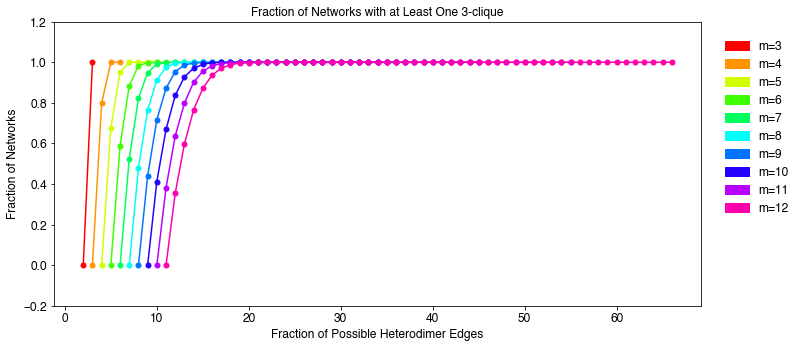

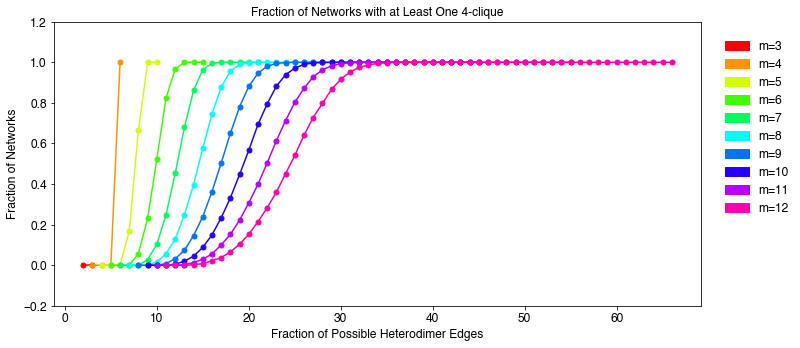

In [ ]:
cmap = cm.get_cmap('hsv')
rng = np.random.default_rng()

# For legend
patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

# For each clique size
for size_i,size in enumerate(size_options):
    fig, ax = plt.subplots(figsize=(10,5))
    
    # Iterate over network size (each will be a different color)
    for m_i, m in enumerate(m_list):
        num_cliques_by_hetero_edges_by_paramset = np.load(str(pathlib.Path(out_dir,f'{m}M_num_{size}cliques_by_hetero_edges_by_paramset.npy')),allow_pickle=True)
        fraction_paramsets_with_clique_byheteroedges = [np.where(num_cliques_by_hetero_edges_by_paramset[hetero_edges_i]>0)[0].shape[0]/\
                                                        num_cliques_by_hetero_edges_by_paramset[hetero_edges_i].shape[0]\
                                                        for hetero_edges_i in range(len(num_cliques_by_hetero_edges_by_paramset))]
        max_hetero_edges = num_combos(m,r=2)
        min_hetero_edges = m -1
        hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
        ax.plot(hetero_edges_list,fraction_paramsets_with_clique_byheteroedges,\
                marker='.',markersize=10,linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

    _ = ax.set_xlabel('Fraction of Possible Heterodimer Edges')
    _ = ax.set_ylabel(f'Fraction of Networks')
    _ = ax.set_title(f'Fraction of Networks with at Least One {size}-clique')

    # Make legend
    leg = fig.legend(bbox_to_anchor=(1, 0.9), loc='upper left',facecolor='white',\
        handles=list(patches.values()),\
        edgecolor='white')

    _ = ax.set_ylim([-0.2,1.2])

    filename = f'fraction_with_cliques_{size}_by_fraction_hetero_edges'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

Then plot for fraction of networks with cliques, including the input monomer:

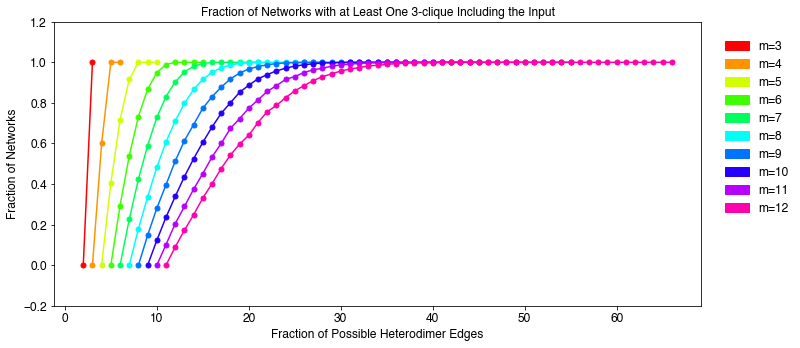

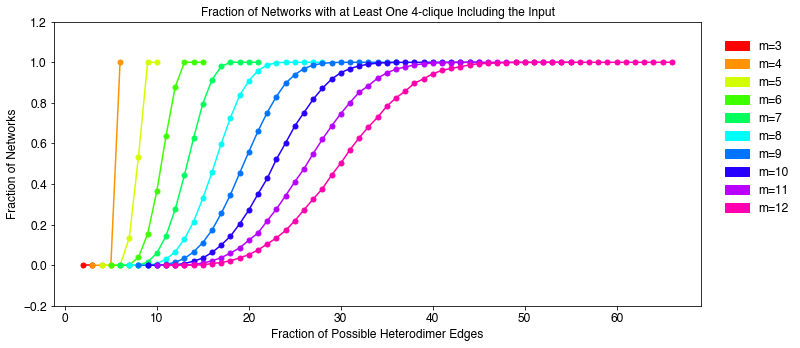

In [ ]:
cmap = cm.get_cmap('hsv')
rng = np.random.default_rng()

# For legend
patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

# For each clique size
for size_i,size in enumerate(size_options):
    fig, ax = plt.subplots(figsize=(10,5))
    
    # Iterate over network size (each will be a different color)
    for m_i, m in enumerate(m_list):
        num_cliques_withinput_by_hetero_edges_by_paramset = np.load(str(pathlib.Path(out_dir,f'{m}M_num_{size}cliques_withinput_by_hetero_edges_by_paramset.npy')),allow_pickle=True)
        max_hetero_edges = num_combos(m,r=2)
        min_hetero_edges = m -1
        hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
        fraction_paramsets_with_clique_byheteroedges = [np.where(num_cliques_withinput_by_hetero_edges_by_paramset[hetero_edges_i]>0)[0].shape[0]/\
                                                    num_cliques_withinput_by_hetero_edges_by_paramset[hetero_edges_i].shape[0]\
                                                    for hetero_edges_i in range(len(num_cliques_withinput_by_hetero_edges_by_paramset))]
        ax.plot(hetero_edges_list,fraction_paramsets_with_clique_byheteroedges,\
                marker='.',markersize=10,linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

    _ = ax.set_xlabel('Fraction of Possible Heterodimer Edges')
    _ = ax.set_ylabel(f'Fraction of Networks')
    _ = ax.set_title(f'Fraction of Networks with at Least One {size}-clique Including the Input')

    # Make legend
    leg = fig.legend(bbox_to_anchor=(1, 0.9), loc='upper left',facecolor='white',\
        handles=list(patches.values()),\
        edgecolor='white')

    _ = ax.set_ylim([-0.2,1.2])

    filename = f'fraction_with_cliques_{size}_withinput_by_fraction_hetero_edges'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

The plot the total number of dimers in cliques:

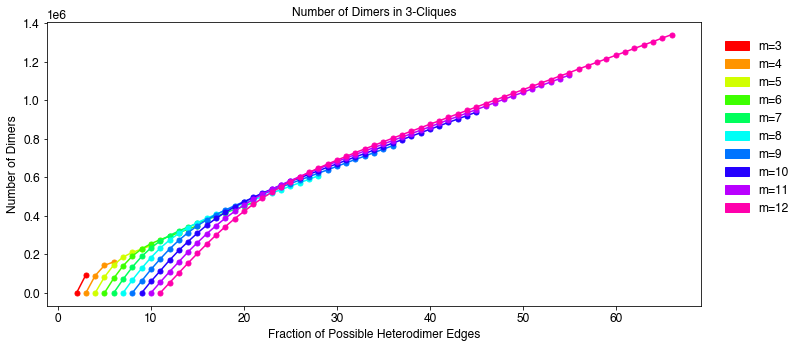

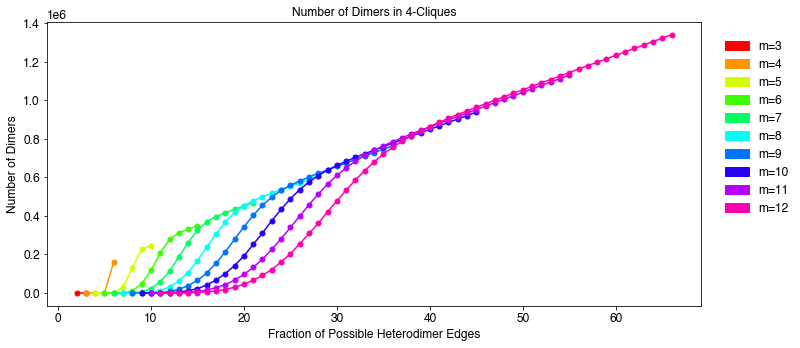

In [ ]:
cmap = cm.get_cmap('hsv')
rng = np.random.default_rng()

# For legend
patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

# For each clique size
for size_i,size in enumerate(size_options):
    fig, ax = plt.subplots(figsize=(10,5))
    
    # Iterate over network size (each will be a different color)
    for m_i, m in enumerate(m_list):
        num_dimersinclique_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_num_dimersin{size}clique_by_hetero_edges.npy')),allow_pickle=True)
        max_hetero_edges = num_combos(m,r=2)
        min_hetero_edges = m -1
        hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
        ax.plot(hetero_edges_list,num_dimersinclique_by_hetero_edges,\
                marker='.',markersize=10,linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

    _ = ax.set_xlabel('Fraction of Possible Heterodimer Edges')
    _ = ax.set_ylabel(f'Number of Dimers')
    _ = ax.set_title(f'Number of Dimers in {size}-Cliques')

    # Make legend
    leg = fig.legend(bbox_to_anchor=(1, 0.9), loc='upper left',facecolor='white',\
        handles=list(patches.values()),\
        edgecolor='white')
    
    filename = f'dimers_in_cliques_{size}_by_fraction_hetero_edges'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

As well as the total number of dimers in cliques with the input monomer:

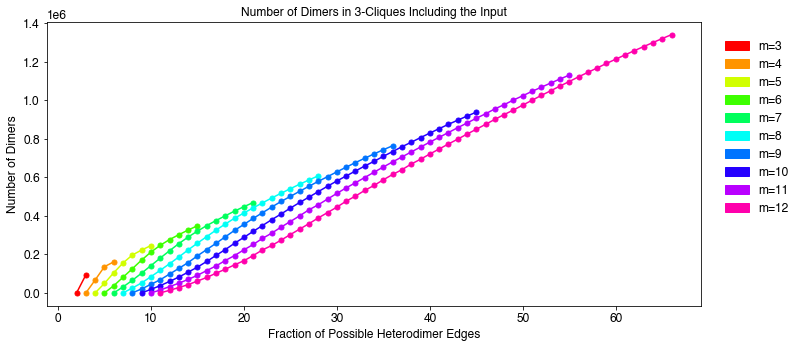

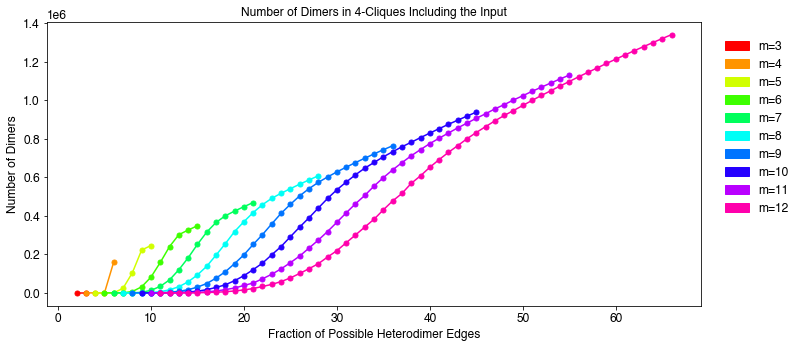

In [ ]:
cmap = cm.get_cmap('hsv')
rng = np.random.default_rng()

# For legend
patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

# For each clique size
for size_i,size in enumerate(size_options):
    fig, ax = plt.subplots(figsize=(10,5))
    
    # Iterate over network size (each will be a different color)
    for m_i, m in enumerate(m_list):
        num_dimersinclique_withinput_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_num_dimersin{size}clique_withinput_by_hetero_edges.npy')),allow_pickle=True)
        max_hetero_edges = num_combos(m,r=2)
        min_hetero_edges = m -1
        hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
        ax.plot(hetero_edges_list,num_dimersinclique_withinput_by_hetero_edges,\
                marker='.',markersize=10,linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

    _ = ax.set_xlabel('Fraction of Possible Heterodimer Edges')
    _ = ax.set_ylabel(f'Number of Dimers')
    _ = ax.set_title(f'Number of Dimers in {size}-Cliques Including the Input')

    # Make legend
    leg = fig.legend(bbox_to_anchor=(1, 0.9), loc='upper left',facecolor='white',\
        handles=list(patches.values()),\
        edgecolor='white')
    
    filename = f'dimers_in_cliques_{size}_withinput_by_fraction_hetero_edges'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Cycles

Finally, we consider "cycles," which appear as rings in the network diagram. We consider cycles of length 4 here. As with cliques, we expect cycles to be more common in densely connected networks, and were interested in them because they might allow for particular types of functions to be computed.

We will first identify all cycles of length 4 in all parameter sets

In [ ]:
min_affinity = 1e-5 # Affinity cutoff to be counted as an "edge"

# Iterate over network size
for m in m_list:
    m_i = m_list.index(m)
    print(f"Working on m={m}")
    # Load parameter sets and info about which dimers are possible to form
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'K_A_param_sets.npy')),allow_pickle=True)
    dimers_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_dimers_by_param_set.npy')),allow_pickle=True)

    # Categorize edges as homodimer or heterodimer
    homo_edges = []
    hetero_edges = []
    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)
    homo_edges = np.array(homo_edges)
    hetero_edges = np.array(hetero_edges)
    dimer_ids = list(itertools.combinations_with_replacement(range(m),r=2))
    possible_hetero_edges = np.array(list(itertools.combinations(range(m),r=2)))

    # Make a Networkx object for each parameter set
    G_base = nx.Graph()
    G_base.add_nodes_from(list(range(m)))
    cycles_by_param_set = np.zeros((param_sets.shape[0],),dtype=np.int64)
    cycles_by_param_set_withinput = np.zeros((param_sets.shape[0],),dtype=np.int64)
    in_cycle_by_param_set_by_dimer = np.zeros((param_sets.shape[0],num_combos_with_replacement(m,2)),dtype=np.int64)
    in_cycle_withinput_by_param_set_by_dimer = np.zeros((param_sets.shape[0],num_combos_with_replacement(m,2)),dtype=np.int64)
    # Iterate over parameter sets
    for param_set in progressbar.progressbar(range(param_sets.shape[0])):
        G = G_base.copy()
        G.add_edges_from(possible_hetero_edges[np.where(param_sets[param_set,hetero_edges]>=min_affinity)[0]])
        # Use nx.cycle_basis to find cycles of length 3 and 4
        cycles = list(nx.cycle_basis(G))
        cycles3 = [x for x in cycles if len(x)==3]
        cycles4 = [x for x in cycles if len(x)==4]
        # Because this only returns a cycle "basis," we need to combine cycles to find cycles of length 4
        cycles3_combos = [list(set(combo[0]).union(set(combo[1]))) for combo in itertools.combinations(list(nx.cycle_basis(G)),r=2)]
        cycles4 += [x for x in cycles3_combos if len(x)==4]
        cycles4_withinput = [x for x in cycles4 if 0 in x]
        where_dimers = np.where(dimers_by_param_set[param_set])[0]
        monomers_in_cycles4= np.unique(list(itertools.chain.from_iterable(cycles4)))
        dimers_in_cycles4= [i for i,x in enumerate(dimer_ids) if x[0] in monomers_in_cycles4 or x[1] in monomers_in_cycles4]
        dimers_in_cycles4= np.intersect1d(np.array(dimers_in_cycles4),where_dimers).astype(np.int64)
        in_cycle_by_param_set_by_dimer[param_set,dimers_in_cycles4]= 1
        #
        monomers_in_cycles4= np.unique(list(itertools.chain.from_iterable(cycles4_withinput)))
        dimers_in_cycles4 = [i for i,x in enumerate(dimer_ids) if x[0] in monomers_in_cycles4 or x[1] in monomers_in_cycles4]
        dimers_in_cycles4 = np.intersect1d(np.array(dimers_in_cycles4),where_dimers).astype(np.int64)
        in_cycle_withinput_by_param_set_by_dimer[param_set,dimers_in_cycles4]= 1
        #
        cycles_by_param_set[param_set] = len(cycles4)
        cycles_by_param_set_withinput[param_set] = len(cycles4_withinput)
    np.save(str(pathlib.Path(out_dir,f'{m}M_num_4cycles_by_param_set.npy')),cycles_by_param_set)
    np.save(str(pathlib.Path(out_dir,f'{m}M_num_4cycles_withinput_by_param_set.npy')),cycles_by_param_set_withinput)
    np.save(str(pathlib.Path(out_dir,f'{m}M_dimersin_4cycles_by_param_set.npy')),in_cycle_by_param_set_by_dimer)
    np.save(str(pathlib.Path(out_dir,f'{m}M_dimersin_4cycles_withinput_by_param_set.npy')),in_cycle_withinput_by_param_set_by_dimer)

Then we see how the prevalence of cycles changes with newtork connectivity

In [ ]:
# We will bootstrap parameter sets to ensure different network sizes have equivalent numbers of networks per connectivity value
num_sets_per_num_edges_by_m = np.load(str(pathlib.Path(out_dir,f'num_sets_per_num_edges_by_m.npy')),allow_pickle=True)

min_sets_per_num_edges = np.min(num_sets_per_num_edges_by_m) # Minimum number of parameter sets for a particular connectivity value; so we will bootstrap this many parameter sets
num_bootstrap_samples = 5 # Number of bootstrap samples to take
rng = np.random.default_rng()

In [ ]:
# Iterate over network sizes
for m in m_list:
    m_i = m_list.index(m)
    print(f"Processing m={m}")
    max_hetero_edges = num_combos(m,r=2)
    max_homo_edges = m
    min_hetero_edges = m-1
    num_S_all_chunks = len(filtered_curves_per_Sall_chunk_by_m[m_i])
    # Load data
    param_sets = np.load(str(pathlib.Path(load_dir,f'{m}M_{load_dir_i}',f'K_A_param_sets.npy')),allow_pickle=True)
    cycles_by_param_set = np.load(str(pathlib.Path(out_dir,f'{m}M_num_4ycles_by_param_set.npy')),allow_pickle=True)
    cycles_by_param_set_withinput = np.load(str(pathlib.Path(out_dir,f'{m}M_num_4cycles_withinput_by_param_set.npy')),allow_pickle=True)
    in_cycle_by_param_set_by_dimer = np.load(str(pathlib.Path(out_dir,f'{m}M_dimersin_4cycles_by_param_set.npy')),allow_pickle=True)
    in_cycle_withinput_by_param_set_by_dimer = np.load(str(pathlib.Path(out_dir,f'{m}M_dimersin_4cycles_withinput_by_param_set.npy')),allow_pickle=True)
    
    # Categorize edges as homodimer or heterodimer
    homo_edges = []
    hetero_edges = []

    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)

    # Count heterodimer edges per parameter set
    hetero_edges_by_param_set = np.apply_along_axis(count_edges, 1, param_sets[:,hetero_edges])
    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
    
    num_cycles_by_hetero_edges_by_paramset = []
    num_cycles_withinput_by_hetero_edges_by_paramset = []
    num_dimersincycle_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    num_dimersincycle_withinput_by_hetero_edges = [[] for num_hetero_edges in hetero_edges_list]
    # Iterate over network connectivity (i.e., number of heterodimer edges)
    for num_hetero_edges_i,num_hetero_edges in enumerate(progressbar.progressbar(hetero_edges_list)):
        # Identify parameter sets with this number of edges
        param_set_idx_with_num_edges = np.where(hetero_edges_by_param_set==num_hetero_edges)[0]
        # For number of cliques per parameter set, no need for boostrapping
        num_cycles_by_hetero_edges_by_paramset.append(cycles_by_param_set[param_set_idx_with_num_edges])
        num_cycles_withinput_by_hetero_edges_by_paramset.append(cycles_by_param_set_withinput[param_set_idx_with_num_edges])
        # But to have a fair comparison for number of dimers, need to bootstrap
        for bootstrap_i in range(num_bootstrap_samples_temp):
            param_set_idx_with_num_edges_bootstrap = rng.choice(param_set_idx_with_num_edges,size=(min_sets_per_num_edges,),replace=False)
            num_dimersincycle_by_hetero_edges[num_hetero_edges_i].append(np.sum(in_cycle_by_param_set_by_dimer[param_set_idx_with_num_edges_bootstrap,:]))
            num_dimersincycle_withinput_by_hetero_edges[num_hetero_edges_i].append(np.sum(in_cycle_withinput_by_param_set_by_dimer[param_set_idx_with_num_edges_bootstrap,:]))
    np.save(str(pathlib.Path(out_dir,f'{m}M_num_4cycles_by_hetero_edges_by_paramset.npy')),num_cycles_by_hetero_edges_by_paramset)
    np.save(str(pathlib.Path(out_dir,f'{m}M_num_4cycles_withinput_by_hetero_edges_by_paramset.npy')),num_cycles_withinput_by_hetero_edges_by_paramset)
    np.save(str(pathlib.Path(out_dir,f'{m}M_num_dimersin4cycle_by_hetero_edges.npy')),num_dimersincycle_by_hetero_edges)
    np.save(str(pathlib.Path(out_dir,f'{m}M_num_dimersin4cycle_withinput_by_hetero_edges.npy')),num_dimersincycle_withinput_by_hetero_edges)

And plot, first the fraction of networks with a 4-cycle:

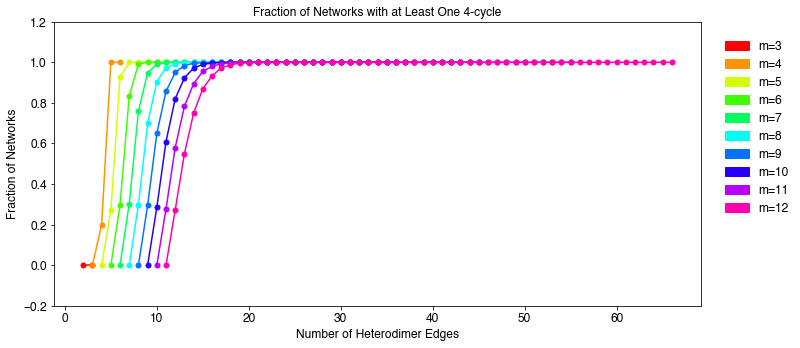

In [ ]:
cmap = cm.get_cmap('hsv')
rng = np.random.default_rng()

# For legend
patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

fig, ax = plt.subplots(figsize=(10,5))

# Iterate over network sizes
for m_i, m in enumerate(m_list):
    num_cycles_by_hetero_edges_by_paramset = np.load(str(pathlib.Path(out_dir,f'{m}M_num_4cycles_by_hetero_edges_by_paramset.npy')),allow_pickle=True)
    fraction_paramsets_with_cycle_byheteroedges = [np.where(num_cycles_by_hetero_edges_by_paramset[hetero_edges_i]>0)[0].shape[0]/\
                                                    num_cycles_by_hetero_edges_by_paramset[hetero_edges_i].shape[0]\
                                                    for hetero_edges_i in range(len(num_cycles_by_hetero_edges_by_paramset))]
    max_hetero_edges = num_combos(m,r=2)
    min_hetero_edges = m -1
    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
    ax.plot(hetero_edges_list,fraction_paramsets_with_cycle_byheteroedges,\
            marker='.',markersize=10,linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel(f'Fraction of Networks')
_ = ax.set_title(f'Fraction of Networks with at Least One 4-cycle')

# Make legend
leg = fig.legend(bbox_to_anchor=(1, 0.9), loc='upper left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

_ = ax.set_ylim([-0.2,1.2])

filename = f'fraction_with_cycles_4_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

Then plot the fraction of networks with a 4-cycle including the input monomer:

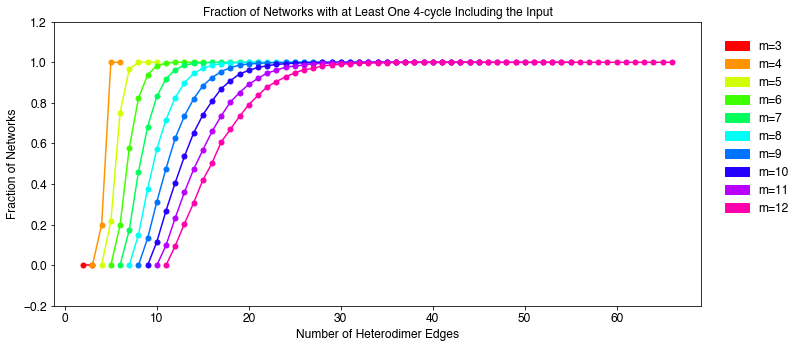

In [ ]:
cmap = cm.get_cmap('hsv')
rng = np.random.default_rng()

# For legend
patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

fig, ax = plt.subplots(figsize=(10,5))

# Iterate over network sizes
for m_i, m in enumerate(m_list):
    num_cycles_withinput_by_hetero_edges_by_paramset = np.load(str(pathlib.Path(out_dir,f'{m}M_num_4cycles_withinput_by_hetero_edges_by_paramset.npy')),allow_pickle=True)
    max_hetero_edges = num_combos(m,r=2)
    min_hetero_edges = m -1
    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
    fraction_paramsets_with_cycle_byheteroedges = [np.where(num_cycles_withinput_by_hetero_edges_by_paramset[hetero_edges_i]>0)[0].shape[0]/\
                                                num_cycles_withinput_by_hetero_edges_by_paramset[hetero_edges_i].shape[0]\
                                                for hetero_edges_i in range(len(num_cycles_withinput_by_hetero_edges_by_paramset))]
    ax.plot(hetero_edges_list,fraction_paramsets_with_cycle_byheteroedges,\
            marker='.',markersize=10,linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel(f'Fraction of Networks')
_ = ax.set_title(f'Fraction of Networks with at Least One 4-cycle Including the Input')

# Make legend
leg = fig.legend(bbox_to_anchor=(1, 0.9), loc='upper left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

_ = ax.set_ylim([-0.2,1.2])

filename = f'fraction_with_cycles_4_withinput_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

Then plot the number of dimers in 4-cycles:

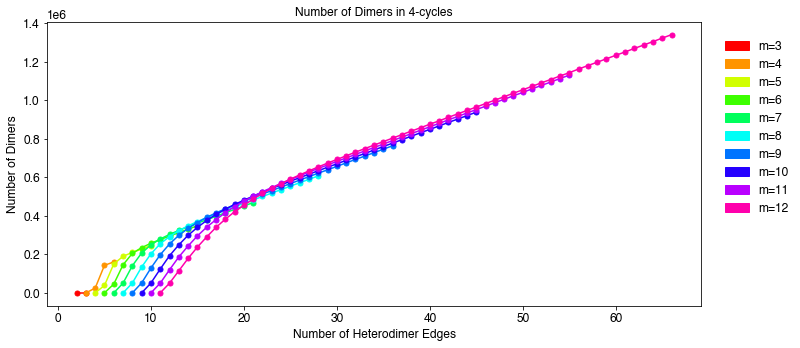

In [ ]:
cmap = cm.get_cmap('hsv')
rng = np.random.default_rng()

# For legend
patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

fig, ax = plt.subplots(figsize=(10,5))

# Iterate over network sizes
for m_i, m in enumerate(m_list):
    num_dimersincycle_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_num_dimersin4cycle_by_hetero_edges.npy')),allow_pickle=True)
    max_hetero_edges = num_combos(m,r=2)
    min_hetero_edges = m -1
    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
    ax.plot(hetero_edges_list,num_dimersincycle_by_hetero_edges,\
            marker='.',markersize=10,linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel(f'Number of Dimers')
_ = ax.set_title(f'Number of Dimers in 4-cycles')

# Make legend
leg = fig.legend(bbox_to_anchor=(1, 0.9), loc='upper left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'dimers_in_cycles_4_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

Then, finally, plot the number of dimers in 4-cycles including the input monomer

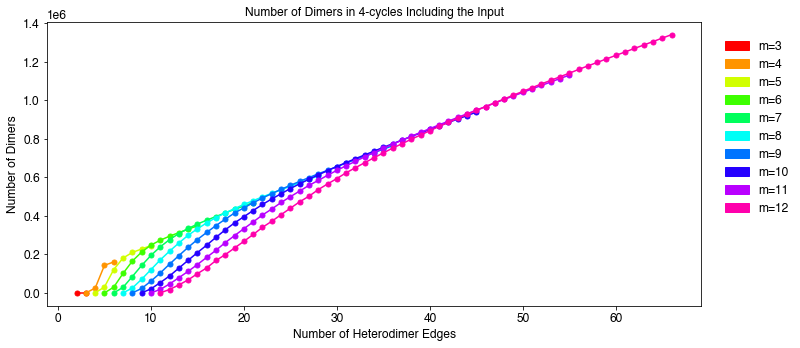

In [ ]:
cmap = cm.get_cmap('hsv')
rng = np.random.default_rng()

# For legend
patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

fig, ax = plt.subplots(figsize=(10,5))

# Iterate over network sizes
for m_i, m in enumerate(m_list):
    num_dimersincycle_withinput_by_hetero_edges = np.load(str(pathlib.Path(out_dir,f'{m}M_num_dimersin4cycle_withinput_by_hetero_edges.npy')),allow_pickle=True)
    max_hetero_edges = num_combos(m,r=2)
    min_hetero_edges = m -1
    hetero_edges_list = list(range(min_hetero_edges,max_hetero_edges+1))
    ax.plot(hetero_edges_list,num_dimersincycle_withinput_by_hetero_edges,\
            marker='.',markersize=10,linestyle='-',color=cmap(m_i/(len(m_list))),alpha=1)

_ = ax.set_xlabel('Number of Heterodimer Edges')
_ = ax.set_ylabel(f'Number of Dimers')
_ = ax.set_title(f'Number of Dimers in 4-cycles Including the Input')

# Make legend
leg = fig.legend(bbox_to_anchor=(1, 0.9), loc='upper left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'dimers_in_cycles_4_withinput_by_hetero_edges'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')